## Import Libraries

In [1]:
# Fix randomness and hide warnings
seed = 38

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft, fftfreq
from scipy.signal import resample
import scipy.stats as stats
import pandas as pd

## Load data

In [2]:
# Data Loading

import zipfile
import os

# Conditional check for unzipping
unzip = True
zip_source = f"train_set.zip"
zip_dest = f"/train_set"

# Unzip the 'public_data.zip' file if the 'unzip' flag is True
if unzip:
  zip = zipfile.ZipFile(zip_source)
  zip.extractall(zip_dest) # insert directory in which you want to save the unzipped file
  zip.close()

## Make dictionaries 

In [3]:
# Initialize an empty dictionary to store data by subject and frequency
subjects_dict = {}

# Iterate through the list of files in the specified directory
for f in os.listdir(f"{zip_dest}/train"):
    # Split the filename to extract subject, frequency, and optional file type
    subject, freq_raw, *type_file_raw = f.split("_")

    # Determine the file type and frequency from the filename
    if not type_file_raw:
        type_file = "ppg"  # Default file type if not specified
        freq = int(freq_raw.split(".")[0])  # Extract frequency from freq_raw
    else:
        type_file = type_file_raw[0].split(".")[0]  # Extract file type
        freq = int(freq_raw)  # Convert frequency to integer

    # Initialize nested dictionaries if the subject or frequency does not exist
    if subject not in subjects_dict:
        subjects_dict[subject] = dict()
    if freq not in subjects_dict[subject]:
        subjects_dict[subject][freq] = dict()

    # Store the filename in the appropriate nested dictionary
    subjects_dict[subject][freq][type_file] = f

# Function to find files by subject and frequency
def find_by_subject_frequency(subject: str, freq: int):
    if subject not in subjects_dict:
        return {}  # Return empty dictionary if subject not found
    if freq not in subjects_dict[subject]:
        return {}  # Return empty dictionary if frequency not found

    return subjects_dict[subject][freq]  # Return dictionary of files for the given subject and frequency

# Function to find files by frequency across all subjects
def find_by_frequency(freq: int):
    relevant_subjects = {}

    # Iterate through all subjects and their frequencies
    for subject, freq_dict in subjects_dict.items():
        if freq in freq_dict:
            relevant_subjects[subject] = freq_dict[freq]  # Add subject and its files if frequency matches

    return relevant_subjects  # Return dictionary of subjects and their files for the given frequency

# Dictionary to count the number of frequencies each subject has
subject_frequencies = {}

# Iterate through all subjects and their frequency dictionaries
for subject, frequency_dict in subjects_dict.items():
    count = len(frequency_dict.keys())  # Count the number of frequencies for the subject
    if count not in subject_frequencies:
        subject_frequencies[count] = [subject]  # Initialize list if count not in dictionary
    else:
        subject_frequencies[count].append(subject)  # Append subject to existing list

# Uncomment the lines below to see examples of usage
# print(subjects_dict["S006"][128])
# find_by_frequency(128)

In [4]:
def get_labels(mat_file_path_ann):
    data = loadmat(mat_file_path_ann)  # Load the .mat file
    if 'labels' in data:
        # MATLAB might wrap these in an array; extract appropriately
        labels = data['labels'].flatten()
        return labels
    else:
        return None

def show_peaks(mat_file_path_spk):
    datas = loadmat(mat_file_path_spk)
    if 'speaks' in datas:
      return datas['speaks'].flatten()
    return None

def show_ppg(mat_file_path_ppg):
    datap = loadmat(mat_file_path_ppg)
    if 'ppg' in datap:
      ppg = datap['ppg'].flatten()
      return ppg
    else:
      return None

In [5]:
# # Define the ranges for plotting
# range1_start, range1_end = 1000, 2000
# range2_start, range2_end = 10000, 11000

# # Iterate through each subject and frequency in subjects_dict
# for subject, freq_dict in subjects_dict.items():
#     for freq, type_dict in freq_dict.items():
#         if 'ppg' in type_dict and 'spk' in type_dict:
#             ppg = show_ppg(f"{zip_dest}/train/{type_dict['ppg']}")
#             peaks = show_peaks(f"{zip_dest}/train/{type_dict['spk']}")

#             # Check if data is loaded correctly
#             if ppg is None or peaks is None:
#                 print(f"Data could not be loaded correctly for Subject: {subject}, Frequency: {freq}")
#                 continue

#             # Ensure peaks are integers
#             peaks = np.array(peaks, dtype=int)

#             # Create the plots
#             fig, axs = plt.subplots(2, 1, figsize=(10, 6))

#             # Plot the PPG signal and show the first range of samples
#             axs[0].plot(np.arange(range1_start, range1_end), ppg[range1_start:range1_end])
#             axs[0].set_title(f'Subject: {subject}, Frequency: {freq} - PPG Signal (Samples {range1_start} to {range1_end})')
#             axs[0].set_xlabel('Sample Index')
#             axs[0].set_ylabel('Amplitude')

#             # Mark peaks on the first plot (within the range of 1000 to 2000)
#             peaks_in_range_1 = [p for p in peaks if range1_start <= p < range1_end]
#             axs[0].scatter(peaks_in_range_1, ppg[peaks_in_range_1], color='r', marker='x', label='Peaks')
#             axs[0].legend()

#             # Plot the PPG signal for the second range of samples
#             axs[1].plot(np.arange(range2_start, range2_end), ppg[range2_start:range2_end])
#             axs[1].set_title(f'Subject: {subject}, Frequency: {freq} - PPG Signal (Samples {range2_start} to {range2_end})')
#             axs[1].set_xlabel('Sample Index')
#             axs[1].set_ylabel('Amplitude')

#             # Mark peaks on the second plot (within the range of 10000 to 11000)
#             peaks_in_range_2 = [p for p in peaks if range2_start <= p < range2_end]
#             axs[1].scatter(peaks_in_range_2, ppg[peaks_in_range_2], color='r', marker='x', label='Peaks')
#             axs[1].legend()

#             plt.tight_layout()
#             plt.show()

## Label Count

In [6]:
# Count the number of signals at 250Hz and at 128Hz

freq_250 = 0
freq_128 = 0

for subject, freq_dict in subjects_dict.items():
    for freq, type_dict in freq_dict.items():
        if freq == 250:
            freq_250 += 1
        elif freq == 128:
            freq_128 += 1

print(f"Number of signals at 250Hz: {freq_250}")
print(f"Number of signals at 128Hz: {freq_128}")

Number of signals at 250Hz: 43
Number of signals at 128Hz: 62


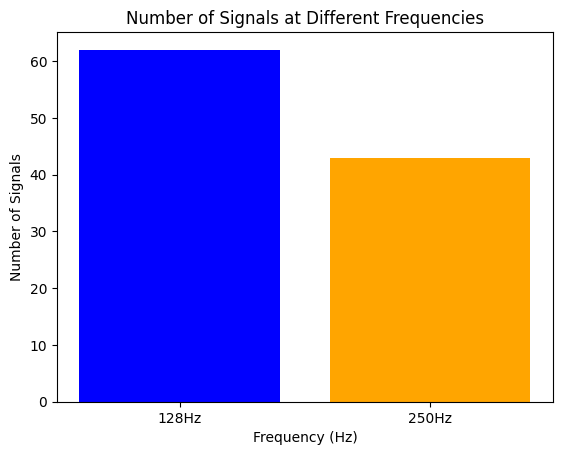

In [7]:
# Prepare data for histogram
frequencies = ['128Hz', '250Hz']
counts = [freq_128, freq_250]

# Create histogram
plt.bar(frequencies, counts, color=['blue', 'orange'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Number of Signals')
plt.title('Number of Signals at Different Frequencies')
plt.show()

Total Label Counts: {'N': 228929, 'S': 9691, 'V': 7994}
Percentage Label Counts: {'N': '92.83%', 'S': '3.93%', 'V': '3.24%'}


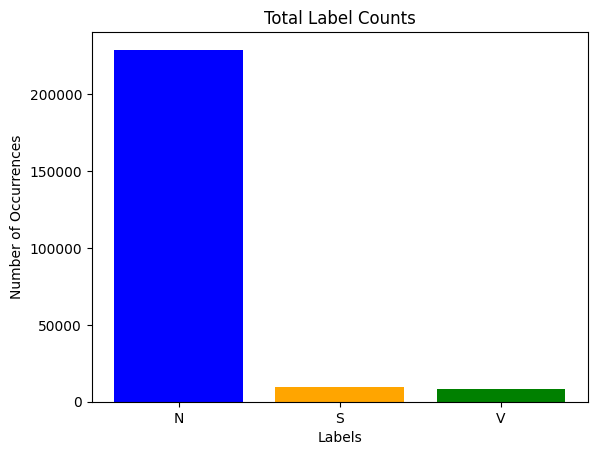

In [8]:
# Count for every subject the number of N, S, V labels

def count_labels(labels):
    label_counts = {
        'N': 0,
        'S': 0,
        'V': 0
    }

    for label in labels:
        if label == 'N':
            label_counts['N'] += 1
        elif label == 'S':
            label_counts['S'] += 1
        elif label == 'V':
            label_counts['V'] += 1

    return label_counts

# Assuming you have already defined get_labels function

# Initialize the dictionary to store the label counts for each subject

label_counts_dict = {}

# Iterate over the subjects and their frequencies

for subject, freq_dict in subjects_dict.items():
    for freq, type_dict in freq_dict.items():
        file_ann = type_dict.get("ann", None)

        if file_ann:
            mat_file_path_ann = f"{zip_dest}/train/{file_ann}"
            labels = get_labels(mat_file_path_ann)

            if labels is not None:
                label_counts = count_labels(labels)
                label_counts_dict[(subject, freq)] = label_counts

# Print the total label count for every category and their percentage

total_label_counts = {
    'N': 0,
    'S': 0,
    'V': 0
}

for label_counts in label_counts_dict.values():
    total_label_counts['N'] += label_counts['N']
    total_label_counts['S'] += label_counts['S']
    total_label_counts['V'] += label_counts['V']

# Percentage Calculation
total_labels = sum(total_label_counts.values())
percentage_label_counts = {label: count / total_labels * 100 for label, count in total_label_counts.items()}
percentage_label_counts = {label: f"{count:.2f}%" for label, count in percentage_label_counts.items()}

print(f"Total Label Counts: {total_label_counts}")
print(f"Percentage Label Counts: {percentage_label_counts}")

# Prepare data for histogram
labels = ['N', 'S', 'V']
counts = [total_label_counts['N'], total_label_counts['S'], total_label_counts['V']]
colors = ['blue', 'orange', 'green']

# Create histogram
plt.bar(labels, counts, color=colors)
plt.xlabel('Labels')
plt.ylabel('Number of Occurrences')
plt.title('Total Label Counts')
plt.show()

In [9]:
# Print subjects with no V or S labels and their frequencies and label counts (if any)

for (subject, freq), label_counts in label_counts_dict.items():
    if label_counts['V'] == 0 and label_counts['S'] == 0:
        print(f"Subject: {subject}, Frequency: {freq}, Label Counts: {label_counts}")

Subject: S085, Frequency: 250, Label Counts: {'N': 2025, 'S': 0, 'V': 0}
Subject: S092, Frequency: 250, Label Counts: {'N': 1878, 'S': 0, 'V': 0}
Subject: S095, Frequency: 250, Label Counts: {'N': 2556, 'S': 0, 'V': 0}
Subject: S096, Frequency: 250, Label Counts: {'N': 2114, 'S': 0, 'V': 0}
Subject: S104, Frequency: 250, Label Counts: {'N': 2914, 'S': 0, 'V': 0}
Subject: S105, Frequency: 250, Label Counts: {'N': 2409, 'S': 0, 'V': 0}
Subject: S107, Frequency: 250, Label Counts: {'N': 591, 'S': 0, 'V': 0}
Subject: S108, Frequency: 250, Label Counts: {'N': 1847, 'S': 0, 'V': 0}
Subject: S110, Frequency: 250, Label Counts: {'N': 3509, 'S': 0, 'V': 0}
Subject: S111, Frequency: 250, Label Counts: {'N': 1938, 'S': 0, 'V': 0}
Subject: S115, Frequency: 250, Label Counts: {'N': 2298, 'S': 0, 'V': 0}
Subject: S119, Frequency: 250, Label Counts: {'N': 2566, 'S': 0, 'V': 0}
Subject: S120, Frequency: 250, Label Counts: {'N': 1890, 'S': 0, 'V': 0}
Subject: S121, Frequency: 250, Label Counts: {'N': 2

## Remove subjects with only N type beats

In [10]:
# Create a list of subjects and frequencies to delete
to_delete = []

for (subject, freq), label_counts in label_counts_dict.items():
    if label_counts['V'] == 0 and label_counts['S'] == 0:
        to_delete.append((subject, freq))

# Delete the subjects from the dictionary
for subject, freq in to_delete:
    del subjects_dict[subject][freq]
    # If the frequency dictionary for the subject is now empty, delete the subject entry
    if not subjects_dict[subject]:
        del subjects_dict[subject]

# Count the number of signals at 250Hz and at 128Hz
freq_250 = 0
freq_128 = 0

for subject, freq_dict in subjects_dict.items():
    for freq in freq_dict.keys():
        if freq == 250:
            freq_250 += 1
        elif freq == 128:
            freq_128 += 1

print(f"Number of signals at 250Hz: {freq_250}")
print(f"Number of signals at 128Hz: {freq_128}")
print("Keys in subjects_dict:", subjects_dict.keys())

Number of signals at 250Hz: 29
Number of signals at 128Hz: 62
Keys in subjects_dict: dict_keys(['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S059', 'S060', 'S061', 'S062', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S093', 'S094', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S106', 'S109', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118'])


Total Label Counts: {'N': 197665, 'S': 9691, 'V': 7994}
Percentage Label Counts: {'N': '91.79%', 'S': '4.50%', 'V': '3.71%'}


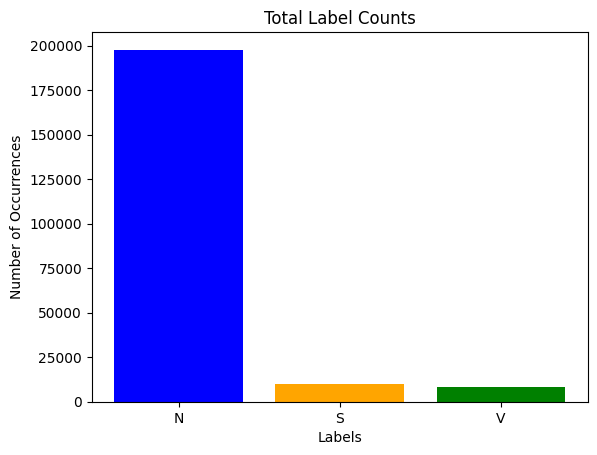

In [11]:
# Do a new label count for every subject

label_counts_dict = {}

for subject, freq_dict in subjects_dict.items():
    for freq, type_dict in freq_dict.items():
        file_ann = type_dict.get("ann", None)

        if file_ann:
            mat_file_path_ann = f"{zip_dest}/train/{file_ann}"
            labels = get_labels(mat_file_path_ann)

            if labels is not None:
                label_counts = count_labels(labels)
                label_counts_dict[(subject, freq)] = label_counts

# Print the total label count for every category

total_label_counts = {
    'N': 0,
    'S': 0,
    'V': 0
}

for label_counts in label_counts_dict.values():
    total_label_counts['N'] += label_counts['N']
    total_label_counts['S'] += label_counts['S']
    total_label_counts['V'] += label_counts['V']

# Percentage Calculation
total_labels = sum(total_label_counts.values())
percentage_label_counts = {label: count / total_labels * 100 for label, count in total_label_counts.items()}
percentage_label_counts = {label: f"{count:.2f}%" for label, count in percentage_label_counts.items()}

print(f"Total Label Counts: {total_label_counts}")
print(f"Percentage Label Counts: {percentage_label_counts}")

# Prepare data for histogram
labels = ['N', 'S', 'V']
counts = [total_label_counts['N'], total_label_counts['S'], total_label_counts['V']
]
colors = ['blue', 'orange', 'green']

# Create histogram
plt.bar(labels, counts, color=colors)
plt.xlabel('Labels')
plt.ylabel('Number of Occurrences')
plt.title('Total Label Counts')
plt.show()

## Visualize all remaining plots

In [12]:
# # Define the ranges for plotting
# range1_start, range1_end = 1000, 2000
# range2_start, range2_end = 10000, 11000

# # Iterate through each subject and frequency in subjects_dict
# for subject, freq_dict in subjects_dict.items():
#     for freq, type_dict in freq_dict.items():
#         if 'ppg' in type_dict and 'spk' in type_dict:
#             ppg = show_ppg(f"{zip_dest}/train/{type_dict['ppg']}")
#             peaks = show_peaks(f"{zip_dest}/train/{type_dict['spk']}")

#             # Check if data is loaded correctly
#             if ppg is None or peaks is None:
#                 print(f"Data could not be loaded correctly for Subject: {subject}, Frequency: {freq}")
#                 continue

#             # Ensure peaks are integers
#             peaks = np.array(peaks, dtype=int)

#             # Create the plots
#             fig, axs = plt.subplots(2, 1, figsize=(10, 6))

#             # Plot the PPG signal and show the first range of samples
#             axs[0].plot(np.arange(range1_start, range1_end), ppg[range1_start:range1_end])
#             axs[0].set_title(f'Subject: {subject}, Frequency: {freq} - PPG Signal (Samples {range1_start} to {range1_end})')
#             axs[0].set_xlabel('Sample Index')
#             axs[0].set_ylabel('Amplitude')

#             # Mark peaks on the first plot (within the range of 1000 to 2000)
#             peaks_in_range_1 = [p for p in peaks if range1_start <= p < range1_end]
#             axs[0].scatter(peaks_in_range_1, ppg[peaks_in_range_1], color='r', marker='x', label='Peaks')
#             axs[0].legend()

#             # Plot the PPG signal for the second range of samples
#             axs[1].plot(np.arange(range2_start, range2_end), ppg[range2_start:range2_end])
#             axs[1].set_title(f'Subject: {subject}, Frequency: {freq} - PPG Signal (Samples {range2_start} to {range2_end})')
#             axs[1].set_xlabel('Sample Index')
#             axs[1].set_ylabel('Amplitude')

#             # Mark peaks on the second plot (within the range of 10000 to 11000)
#             peaks_in_range_2 = [p for p in peaks if range2_start <= p < range2_end]
#             axs[1].scatter(peaks_in_range_2, ppg[peaks_in_range_2], color='r', marker='x', label='Peaks')
#             axs[1].legend()

#             plt.tight_layout()
#             plt.show()

## Preprocessing

### Downsampling 250Hz signals

Since we have different sampling frequencies in our dataset, it is essential to equalize them to ensure consistency in analysis. In this context, we will perform downsampling, specifically reducing the 250Hz signals to 128Hz. This approach is chosen because the majority of the signals in our dataset are sampled at 128Hz, making it the standard frequency for our analysis.

Downsampling to a lower frequency, such as 128Hz, offers several benefits:

- Consistency: Having all signals at the same sampling frequency simplifies the analysis and processing pipeline.
- Computational Efficiency: Lower sampling rates reduce the amount of data, leading to faster processing and lower computational costs.
- Storage Efficiency: Downsampling decreases the data size, resulting in more efficient storage use.
- Standardization: By adopting 128Hz as the standard frequency, we align with common practices in signal processing, where lower frequencies are often sufficient for capturing essential information without unnecessary detail.

Before resampling, we need to make sure that no signal with 250Hz frequency, have relevant frequency components above 64Hz, in accordance with the sampling theorem. By plotting the fft of each signal, we were able to assess that this requirement is met. 

In [13]:
# Observation of all the 250Hz signal fft

# Define the sampling frequency
fs = 250  # Sampling frequency in Hz

# Compute iteratively the FFT for all 250Hz signals

for subject, freq_dict in subjects_dict.items():
    for freq, type_dict in freq_dict.items():
        if freq == 250:
            file_ppg = type_dict.get("ppg", None)
            if file_ppg:
                mat_file_path_ppg = f"{zip_dest}/train/{file_ppg}"
                ppg = show_ppg(mat_file_path_ppg)
                if ppg is not None:
                    N = len(ppg)
                    ppg_fft = fft(ppg)

# Compute the frequency values for the FFT
freq_values = fftfreq(N, 1 / fs)

In [14]:
# Plot the FFT results iteratively for all 250Hz signals

# for subject, freq_dict in subjects_dict.items():
#     for freq, type_dict in freq_dict.items():
#         if freq == 250:
#             file_ppg = type_dict.get("ppg", None)
#             if file_ppg:
#                 mat_file_path_ppg = f"{zip_dest}/train/{file_ppg}"
#                 ppg = show_ppg(mat_file_path_ppg)
#                 if ppg is not None:
#                     N = len(ppg)
#                     ppg_fft = fft(ppg)

#                     # Plot the FFT results
#                     plt.figure(figsize=(10, 6))
#                     plt.plot(freq_values[:N // 2], np.abs(ppg_fft)[:N // 2])
#                     plt.title(f"FFT of PPG Signal for Subject: {subject}, Frequency: {freq}Hz")
#                     plt.xlabel('Frequency (Hz)')
#                     plt.ylabel('Magnitude')
#                     plt.grid(True)
#                     plt.show()

In [15]:
# Define the original and target sampling frequencies
original_fs = 250  # Original sampling frequency
target_fs = 128    # Target sampling frequency

# Initialize the final dictionary
final_dict = {}

# Downsample the 250Hz PPG signals to the target frequency and store them in the final dictionary
for subject, freq_dict in subjects_dict.items():
    if subject not in final_dict:
        final_dict[subject] = {}
    for freq, type_dict in freq_dict.items():
        if freq == original_fs:
            file_ppg = type_dict.get("ppg", None)
            if file_ppg:
                mat_file_path_ppg = f"{zip_dest}/train/{file_ppg}"
                ppg = show_ppg(mat_file_path_ppg)
                if ppg is not None:
                    N = len(ppg)
                    resampled_ppg = resample(ppg, int(N * target_fs / original_fs))
                    final_dict[subject]["ppg"] = resampled_ppg
            else:
                print(f"PPG file not found for Subject: {subject}")

            file_spk = type_dict.get("spk", None)
            if file_spk:
                mat_file_path_spk = f"{zip_dest}/train/{file_spk}"
                peaks = show_peaks(mat_file_path_spk)
                if peaks is not None:
                    transformed_peaks = [p * target_fs // original_fs for p in peaks]
                    final_dict[subject]["spk"] = transformed_peaks
                else:
                    print(f"Peaks not found for Subject: {subject}")
            else:
                print(f"SPK file not found for Subject: {subject}")

            file_ann = type_dict.get("ann", None)
            if file_ann:
                ann_file_path = f"{zip_dest}/train/{file_ann}"
                labels = get_labels(ann_file_path)
                if labels is not None:
                    final_dict[subject]["labels"] = labels
                else:
                    print(f"Labels not found for Subject: {subject}")
            else:
                print(f"ANN file not found for Subject: {subject}")

        elif freq == target_fs:
            file_ppg = type_dict.get("ppg", None)
            if file_ppg:
                mat_file_path_ppg = f"{zip_dest}/train/{file_ppg}"
                ppg = show_ppg(mat_file_path_ppg)
                if ppg is not None:
                    final_dict[subject]["ppg"] = ppg
            else:
                print(f"PPG file not found for Subject: {subject}")

            file_spk = type_dict.get("spk", None)
            if file_spk:
                mat_file_path_spk = f"{zip_dest}/train/{file_spk}"
                peaks = show_peaks(mat_file_path_spk)
                if peaks is not None:
                    final_dict[subject]["spk"] = peaks
                else:
                    print(f"Peaks not found for Subject: {subject}")
            else:
                print(f"SPK file not found for Subject: {subject}")

            file_ann = type_dict.get("ann", None)
            if file_ann:
                ann_file_path = f"{zip_dest}/train/{file_ann}"
                labels = get_labels(ann_file_path)
                if labels is not None:
                    final_dict[subject]["labels"] = labels
                else:
                    print(f"Labels not found for Subject: {subject}")
            else:
                print(f"ANN file not found for Subject: {subject}")

# Remove 'ann' key from final_dict if it exists
for subject in final_dict:
    if 'ann' in final_dict[subject]:
        del final_dict[subject]['ann']

# Debugging: Print the keys of the final dictionary
print("Keys in final_dict:", final_dict.keys())

# Print a summary of the keys in final_dict for each subject
for subject, keys in final_dict.items():
    print(f"Subject: {subject}, Keys: {list(keys.keys())}")

Keys in final_dict: dict_keys(['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S059', 'S060', 'S061', 'S062', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S093', 'S094', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S106', 'S109', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118'])
Subject: S001, Keys: ['ppg', 'spk', 'labels']
Subject: S002, Keys: ['ppg', 'spk', 'labels']
Subject: S003, Keys: ['ppg', 'spk', 'labels']
Subject: S004, Keys: ['ppg', 'spk', 'labels']
Subject: S005, Keys: ['ppg', 'spk', 'labels']
Subject: S

In [16]:
# Count the number of PPG signals, SPK (peaks) groups, and labels in the final dictionary
ppg_count = 0
spk_count = 0
lab_count = 0

for subject, type_dict in final_dict.items():
    if 'ppg' in type_dict:
        ppg_count += 1
    if 'spk' in type_dict:
        spk_count += 1
    if 'labels' in type_dict:
        lab_count += 1

print(f"Total number of PPG signals: {ppg_count}")
print(f"Total number of groups of peaks (SPK): {spk_count}")
print(f"Total number of groups of labels: {lab_count}")

# Print lengths of peaks and labels for each subject
for subject, type_dict in final_dict.items():
    if 'ppg' in type_dict and 'spk' in type_dict and 'labels' in type_dict:
        ppg_length = len(type_dict['ppg'])
        peaks_length = len(type_dict['spk'])
        labels_length = len(type_dict['labels'])
        print(f"Subject: {subject}, PPG length: {ppg_length}, Peaks Length: {peaks_length}, Labels Length: {labels_length}")

Total number of PPG signals: 91
Total number of groups of peaks (SPK): 91
Total number of groups of labels: 91
Subject: S001, PPG length: 230388, Peaks Length: 2603, Labels Length: 2603
Subject: S002, PPG length: 230335, Peaks Length: 2349, Labels Length: 2349
Subject: S003, PPG length: 230295, Peaks Length: 1932, Labels Length: 1932
Subject: S004, PPG length: 230371, Peaks Length: 1759, Labels Length: 1759
Subject: S005, PPG length: 230308, Peaks Length: 2687, Labels Length: 2687
Subject: S006, PPG length: 230285, Peaks Length: 2177, Labels Length: 2177
Subject: S007, PPG length: 230312, Peaks Length: 2997, Labels Length: 2997
Subject: S008, PPG length: 230277, Peaks Length: 2344, Labels Length: 2344
Subject: S009, PPG length: 230293, Peaks Length: 2416, Labels Length: 2416
Subject: S010, PPG length: 230356, Peaks Length: 2858, Labels Length: 2858
Subject: S011, PPG length: 230213, Peaks Length: 1957, Labels Length: 1957
Subject: S012, PPG length: 230285, Peaks Length: 1668, Labels Le

In [17]:
# Define the ranges for plotting
# range1_start, range1_end = 1000, 2000
# range2_start, range2_end = 10000, 11000

# # Iterate through each subject in final_dict
# for subject, type_dict in final_dict.items():
#     if 'ppg' in type_dict and 'spk' in type_dict and 'labels' in type_dict:
#         ppg = np.array(type_dict['ppg'])  # Ensure ppg is a numpy array
#         peaks = type_dict['spk']
#         labels = type_dict['labels']

#         # Check if data is loaded correctly
#         if len(ppg) == 0 or len(peaks) == 0 or len(labels) == 0:
#             print(f"Data could not be loaded correctly for Subject: {subject}")
#             continue

#         # Ensure peaks are integers
#         peaks = np.array(peaks, dtype=int)

#         # Create the plots
#         fig, axs = plt.subplots(2, 1, figsize=(10, 6))

#         # Plot the PPG signal and show the first range of samples
#         axs[0].plot(np.arange(range1_start, range1_end), ppg[range1_start:range1_end])
#         axs[0].set_title(f'Subject: {subject} - PPG Signal (Samples {range1_start} to {range1_end})')
#         axs[0].set_xlabel('Sample Index')
#         axs[0].set_ylabel('Amplitude')

#         # Mark peaks on the first plot (within the range of 1000 to 2000)
#         for p in peaks:
#             if range1_start <= p < range1_end:
#                 label = labels[peaks.tolist().index(p)]
#                 if label == 'N':
#                     color = 'g'
#                 elif label == 'S':
#                     color = 'r'
#                 elif label == 'V':
#                     color = 'orange'
#                 axs[0].scatter(p, ppg[p], color=color, marker='x', label=f'Peak {label}')

#         # Plot the PPG signal for the second range of samples
#         axs[1].plot(np.arange(range2_start, range2_end), ppg[range2_start:range2_end])
#         axs[1].set_title(f'Subject: {subject} - PPG Signal (Samples {range2_start} to {range2_end})')
#         axs[1].set_xlabel('Sample Index')
#         axs[1].set_ylabel('Amplitude')

#         # Mark peaks on the second plot (within the range of 10000 to 11000)
#         for p in peaks:
#             if range2_start <= p < range2_end:
#                 label = labels[peaks.tolist().index(p)]
#                 if label == 'N':
#                     color = 'g'
#                 elif label == 'S':
#                     color = 'r'
#                 elif label == 'V':
#                     color = 'orange'
#                 axs[1].scatter(p, ppg[p], color=color, marker='x', label=f'Peak {label}')

#         plt.tight_layout()
#         plt.show()

## Bandpass filtering

The analysis of the FFT of the signals helped also in deciding the low-pass cut-off frequency of the filter. The chosen frequency was 5Hz, given the low frequency content of the signals.
To remove the DC component of the signal, a 0.5Hz high-pass cut-off was chosen.

In [18]:
# Define the Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [19]:
# Define the bandpass filter parameters
lowcut = 0.5
highcut = 5.0
fs = 128  # Sampling frequency for the PPG signals in final_dict

# Apply the bandpass filter to all PPG signals in final_dict
for subject, type_dict in final_dict.items():
    if 'ppg' in type_dict:
        ppg = type_dict['ppg']
        print(f"Subject: {subject}, Original PPG shape: {ppg.shape}")
        
        if ppg.ndim > 1:
            ppg = np.squeeze(ppg)  # Ensure ppg is a 1D numpy array
            print(f"Subject: {subject}, Squeezed PPG shape: {ppg.shape}")
        
        filtered_ppg = apply_bandpass_filter(ppg, lowcut, highcut, fs)
        final_dict[subject]['ppg'] = filtered_ppg

Subject: S001, Original PPG shape: (230388,)
Subject: S002, Original PPG shape: (230335,)
Subject: S003, Original PPG shape: (230295,)
Subject: S004, Original PPG shape: (230371,)
Subject: S005, Original PPG shape: (230308,)
Subject: S006, Original PPG shape: (230285,)
Subject: S007, Original PPG shape: (230312,)
Subject: S008, Original PPG shape: (230277,)
Subject: S009, Original PPG shape: (230293,)
Subject: S010, Original PPG shape: (230356,)
Subject: S011, Original PPG shape: (230213,)
Subject: S012, Original PPG shape: (230285,)
Subject: S013, Original PPG shape: (230209,)
Subject: S014, Original PPG shape: (230341,)
Subject: S015, Original PPG shape: (230279,)
Subject: S016, Original PPG shape: (230346,)
Subject: S017, Original PPG shape: (230312,)
Subject: S018, Original PPG shape: (230342,)
Subject: S019, Original PPG shape: (230332,)
Subject: S020, Original PPG shape: (230435,)
Subject: S021, Original PPG shape: (230323,)
Subject: S022, Original PPG shape: (230312,)
Subject: S

In [20]:
# # Define the ranges for plotting
# range1_start, range1_end = 1000, 2000
# range2_start, range2_end = 10000, 11000

# # Iterate through each subject in final_dict
# for subject, type_dict in final_dict.items():
#     if 'ppg' in type_dict and 'spk' in type_dict and 'labels' in type_dict:
#         ppg = np.array(type_dict['ppg'])  # Ensure ppg is a numpy array
#         peaks = type_dict['spk']
#         labels = type_dict['labels']

#         # Check if data is loaded correctly
#         if len(ppg) == 0 or len(peaks) == 0 or len(labels) == 0:
#             print(f"Data could not be loaded correctly for Subject: {subject}")
#             continue

#         # Ensure peaks are integers
#         peaks = np.array(peaks, dtype=int)

#         # Create the plots
#         fig, axs = plt.subplots(2, 1, figsize=(10, 6))

#         # Plot the PPG signal and show the first range of samples
#         axs[0].plot(np.arange(range1_start, range1_end), ppg[range1_start:range1_end])
#         axs[0].set_title(f'Subject: {subject} - PPG Signal (Samples {range1_start} to {range1_end})')
#         axs[0].set_xlabel('Sample Index')
#         axs[0].set_ylabel('Amplitude')

#         # Mark peaks on the first plot (within the range of 1000 to 2000)
#         for p in peaks:
#             if range1_start <= p < range1_end:
#                 label = labels[peaks.tolist().index(p)]
#                 if label == 'N':
#                     color = 'g'
#                 elif label == 'S':
#                     color = 'r'
#                 elif label == 'V':
#                     color = 'orange'
#                 axs[0].scatter(p, ppg[p], color=color, marker='x', label=f'Peak {label}')

#         # Plot the PPG signal for the second range of samples
#         axs[1].plot(np.arange(range2_start, range2_end), ppg[range2_start:range2_end])
#         axs[1].set_title(f'Subject: {subject} - PPG Signal (Samples {range2_start} to {range2_end})')
#         axs[1].set_xlabel('Sample Index')
#         axs[1].set_ylabel('Amplitude')

#         # Mark peaks on the second plot (within the range of 10000 to 11000)
#         for p in peaks:
#             if range2_start <= p < range2_end:
#                 label = labels[peaks.tolist().index(p)]
#                 if label == 'N':
#                     color = 'g'
#                 elif label == 'S':
#                     color = 'r'
#                 elif label == 'V':
#                     color = 'orange'
#                 axs[1].scatter(p, ppg[p], color=color, marker='x', label=f'Peak {label}')

#         plt.tight_layout()
#         plt.show()

## Normalization of all signals

In [21]:
for subject, type_dict in final_dict.items():
    if 'ppg' in type_dict:
        ppg_signal = type_dict['ppg']
        normalized_ppg = (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)
        final_dict[subject]['ppg'] = normalized_ppg

In [45]:
# # Define the ranges for plotting
# range1_start, range1_end = 0, 1000
# range2_start, range2_end = 10000, 11000

# # Iterate through each subject in final_dict
# for subject, type_dict in final_dict.items():
#     if 'ppg' in type_dict and 'spk' in type_dict and 'labels' in type_dict:
#         ppg = np.array(type_dict['ppg'])  # Ensure ppg is a numpy array
#         peaks = type_dict['spk']
#         labels = type_dict['labels']

#         # Check if data is loaded correctly
#         if len(ppg) == 0 or len(peaks) == 0 or len(labels) == 0:
#             print(f"Data could not be loaded correctly for Subject: {subject}")
#             continue

#         # Ensure peaks are integers
#         peaks = np.array(peaks, dtype=int)

#         # Create the plots
#         fig, axs = plt.subplots(2, 1, figsize=(10, 6))

#         # Plot the PPG signal and show the first range of samples
#         axs[0].plot(np.arange(range1_start, range1_end), ppg[range1_start:range1_end])
#         axs[0].set_title(f'Subject: {subject} - PPG Signal (Samples {range1_start} to {range1_end})')
#         axs[0].set_xlabel('Sample Index')
#         axs[0].set_ylabel('Amplitude')

#         # Mark peaks on the first plot (within the range of 1000 to 2000)
#         for p in peaks:
#             if range1_start <= p < range1_end:
#                 label = labels[peaks.tolist().index(p)]
#                 if label == 'N':
#                     color = 'g'
#                 elif label == 'S':
#                     color = 'r'
#                 elif label == 'V':
#                     color = 'orange'
#                 axs[0].scatter(p, ppg[p], color=color, marker='x', label=f'Peak {label}')

        # # Plot the PPG signal for the second range of samples
        # axs[1].plot(np.arange(range2_start, range2_end), ppg[range2_start:range2_end])
        # axs[1].set_title(f'Subject: {subject} - PPG Signal (Samples {range2_start} to {range2_end})')
        # axs[1].set_xlabel('Sample Index')
        # axs[1].set_ylabel('Amplitude')

        # # Mark peaks on the second plot (within the range of 10000 to 11000)
        # for p in peaks:
        #     if range2_start <= p < range2_end:
        #         label = labels[peaks.tolist().index(p)]
        #         if label == 'N':
        #             color = 'g'
        #         elif label == 'S':
        #             color = 'r'
        #         elif label == 'V':
        #             color = 'orange'
        #         axs[1].scatter(p, ppg[p], color=color, marker='x', label=f'Peak {label}')

        # plt.tight_layout()
        # plt.show()

## Beat Segmentation

In [25]:
# Define a function to extract single beats from a signal using a dynamic window size
def extract_single_beats_dynamically(signal, peak_locations, labels, start_ratio=0.35, end_ratio=0.65):
    """
    Extracts beats from a signal based on the locations of the peaks.

    Args:
        signal (list): The input signal.
        peak_locations (list): The locations of the peaks in the signal.
        labels (list): The labels for each peak.
        start_ratio (float, optional): The ratio of the window size to use as the starting point of the beat extraction.
            Defaults to 0.35.
        end_ratio (float, optional): The ratio of the window size to use as the ending point of the beat extraction.
            Defaults to 0.65.

    Returns:
        list: A list of beats extracted from the signal.
        list: A list of peak positions relative to the start of the window.
        list: A list of labels for each beat.
    """
    beats = []
    peak_positions = []
    beat_labels = []
    for i in range(len(peak_locations)):
        if i == 0:
            window_size = peak_locations[i+1] - peak_locations[i]
        elif i == len(peak_locations) - 1:
            window_size = peak_locations[i] - peak_locations[i-1]
        else:
            window_size = min(peak_locations[i+1] - peak_locations[i], peak_locations[i] - peak_locations[i-1])

        start = int(max(0, peak_locations[i] - window_size*start_ratio))
        end = int(min(len(signal), peak_locations[i] + window_size*end_ratio))
        beat = signal[start:end]
        if start != end:
            beats.append(beat)
            # Calculate the relative position of the peak within the window
            if start > 0:
                peak_position = int(window_size * start_ratio)
            else:
                peak_position = peak_locations[i]
            peak_positions.append(peak_position)
            beat_labels.append(labels[i])

    return beats, peak_positions, beat_labels

# Codice per segmentare tutti i segnali in final_dict e creare il dataset
dataset = []

for subject, type_dict in final_dict.items():
    if 'ppg' in type_dict and 'spk' in type_dict and 'labels' in type_dict:
        ppg = np.array(type_dict['ppg'])  # Assicurarsi che ppg sia un array numpy
        peaks = type_dict['spk']
        labels = type_dict['labels']

        # Segmenta il segnale attorno ai picchi
        beats, peak_positions, beat_labels = extract_single_beats_dynamically(ppg, peaks, labels, start_ratio=0.35, end_ratio=0.65)
        for i in range(len(beats)):
            # Aggiungi l'ID del paziente insieme al beat, la posizione del picco e il label
            dataset.append((subject, beats[i], peak_positions[i], beat_labels[i]))

# Verifica del dataset
print(f"Total number of segments: {len(dataset)}")
# print(f"Example segment: {dataset[0]}")

Total number of segments: 215350


In [26]:
# # Funzione per plottare i battiti con color coding
# def plot_beat(segment, peak_position, label):
#     plt.figure(figsize=(10, 4))
#     plt.plot(segment, label='PPG Segment')
#     plt.scatter([peak_position], [segment[peak_position]], color='r', marker='x', label='Peak')
#     plt.title(f'Beat with label {label}')
#     plt.xlabel('Sample Index')
#     plt.ylabel('Amplitude')
#     plt.legend()
#     plt.show()

# # Creare una lista di segmenti per ogni tipo di etichetta
# segments_N = [seg for seg in dataset if seg[2] == 'N']
# segments_S = [seg for seg in dataset if seg[2] == 'S']
# segments_V = [seg for seg in dataset if seg[2] == 'V']

# # Plot di alcuni esempi dal dataset per ogni tipo di etichetta
# num_examples = 5

# print(f"Plotting {num_examples} examples for label 'N'")
# for i in range(min(num_examples, len(segments_N))):
#     beat, peak_position, label = segments_N[i]
#     plot_beat(beat, peak_position, label)

# print(f"Plotting {num_examples} examples for label 'S'")
# for i in range(min(num_examples, len(segments_S))):
#     beat, peak_position, label = segments_S[i]
#     plot_beat(beat, peak_position, label)

# print(f"Plotting {num_examples} examples for label 'V'")
# for i in range(min(num_examples, len(segments_V))):
#     beat, peak_position, label = segments_V[i]
#     plot_beat(beat, peak_position, label)

## Build the features dataset

In [28]:
def get_beat_FWHM(beat, fs=128):
    """
    Calculates the Full Width at Half Maximum (FWHM) of the beat.

    Args:
        beat (array-like): The input beat.
        fs (int, optional): The sampling frequency in Hz. Defaults to 128.

    Returns:
        float: The FWHM value of the beat in seconds.
    """
    max_val = np.max(beat)
    half_max = max_val / 2.
    indices = np.where(beat > half_max)[0]
    if len(indices) > 0:  # Check if there are any indices found
        fwhm = (indices[-1] - indices[0] + 1) / fs
        return fwhm
    else:
        return 0  # If no indices found, return 0

In [29]:
def calculate_peak_intervals(peaks, fs=128):
    """
    Calculate the time intervals between consecutive peaks.

    Args:
        peaks (list): List of peak indices.
        fs (int): Sampling frequency (in Hz).

    Returns:
        intervals (list): List of time intervals between peaks.
    """
    intervals = []
    for i in range(len(peaks) - 1):
        interval = (peaks[i+1] - peaks[i]) / fs
        intervals.append(interval)

    # For the last peak, use the mean of previous intervals as a probable value
    if intervals:
        probable_interval = np.mean(intervals)
    else:
        probable_interval = 0  # In case there is only one peak, set interval to 0 or another sentinel value
    
    intervals.append(probable_interval)
    
    return intervals

In [30]:
def calculate_fft_features(beat):
    N = len(beat)
    fft_values = fft(beat)
    fft_magnitudes = np.abs(fft_values)[:N//2]  # Prendi solo la metà positiva dello spettro
    return fft_magnitudes[:5]  # Restituisci le prime 5 componenti principali

In [31]:
def extract_features(beat, peak_position, interval=None, subject_id=None, beat_index=None):
    features = {}
    
    # Temporal features
    features['peak_amplitude'] = beat[peak_position] 
    features['rise_time'] = peak_position / fs  # Time in seconds
    features['fall_time'] = (len(beat) - peak_position) / fs  # Time in seconds
    features['beat_duration'] = len(beat) / fs  # Time in seconds
    if interval is not None:
        features['peak_interval'] = interval  # Peak-to-peak interval in seconds
    
    # Morphological features
    features['max_amplitude'] = np.max(beat)
    features['min_amplitude'] = np.min(beat)
    features['mean_amplitude'] = np.mean(beat)
    features['std_amplitude'] = np.std(beat)
    features['range_amplitude'] = np.ptp(beat)
    features['rms'] = np.sqrt(np.mean(np.square(beat)))  # Root Mean Square
    features['area'] = np.sum(np.abs(beat))
    features['FWHM'] = get_beat_FWHM(beat, fs)
    features['energy'] = np.sum(np.square(beat))
    features['systolic_diastolic_ratio'] = features['max_amplitude'] / (features['min_amplitude'] + 1e-10)
    features['rise_fall_ratio'] = features['rise_time'] / (features['fall_time'] + 1e-10)

    # Statistical features
    features['skewness'] = stats.skew(beat)
    features['kurtosis'] = stats.kurtosis(beat)
    
    # Normalize the beat for entropy calculation
    beat_normalized = beat - np.min(beat)
    beat_normalized = beat_normalized / np.sum(beat_normalized + 1e-10)  # Adding a small constant to avoid division by zero

    # Compute entropy
    if np.any(beat_normalized > 0):  # Check if there are any non-zero values
        features['entropy'] = -np.sum(beat_normalized * np.log2(beat_normalized + 1e-10))
    else:
        features['entropy'] = 0
    
    # Frequency features
    freqs, psd = welch(beat, fs=128)
    features['total_power'] = np.sum(psd)
    features['band_power'] = np.sum(psd[(freqs >= 0.5) & (freqs <= 5)])
    features['dominant_frequency'] = freqs[np.argmax(psd)]  # Frequency with maximum power
    features['fft1'] = calculate_fft_features(beat)[0]
    features['fft2'] = calculate_fft_features(beat)[1]
    features['fft3'] = calculate_fft_features(beat)[2]
    features['fft4'] = calculate_fft_features(beat)[3]
    features['fft5'] = calculate_fft_features(beat)[4]
    features['power_ratio'] = features['band_power'] / (features['total_power'] - features['band_power'] + 1e-10)
    
    # Add subject ID as a feature
    if subject_id is not None:
        features['subject_id'] = subject_id
    if beat_index is not None:
        features['beat_index'] = beat_index

    return features, beat


In [32]:
# Create the dataset
feature_matrix = []
labels = []
beats_list = []

for subject, type_dict in final_dict.items():
    if 'ppg' in type_dict and 'spk' in type_dict and 'labels' in type_dict:
        ppg = np.array(type_dict['ppg'])  
        peaks = type_dict['spk']
        labels_list = type_dict['labels']

        # Segment the beats
        beats, peak_positions, beat_labels = extract_single_beats_dynamically(ppg, peaks, labels_list)
        
        # Calculate the intervals between peaks
        intervals = calculate_peak_intervals(peaks)

        # Extract features for each beat
        for i in range(len(beats)):
            beat = beats[i]
            peak_position = peak_positions[i]
            label = beat_labels[i]
            
            # Pass the corresponding interval and beat index
            interval = intervals[i]
            features, original_beat = extract_features(beat, peak_position, interval, subject_id=subject, beat_index=i)
            
            feature_matrix.append(features)
            labels.append(label)
            beats_list.append(original_beat)  # Store the original beat

In [33]:
# Convert feature_matrix to a DataFrame for better visualization
df_features = pd.DataFrame(feature_matrix)
df_labels = pd.Series(labels, name='label')

# Concatenate features and labels into a single DataFrame
df_dataset = pd.concat([df_features, df_labels], axis=1)

In [34]:
df_dataset.head(10)

,peak_amplitude,rise_time,fall_time,beat_duration,peak_interval,max_amplitude,min_amplitude,mean_amplitude,std_amplitude,range_amplitude,...,dominant_frequency,fft1,fft2,fft3,fft4,fft5,power_ratio,subject_id,beat_index,label
0,0.180077,0.218750,0.421875,0.640625,0.640625,0.182377,-0.129712,0.035568,0.101741,0.312089,...,1.560976,2.916588,5.748035,1.265770,0.279039,0.107661,4.196146,S001,0,N
1,0.116188,0.218750,0.421875,0.640625,0.640625,0.116940,-0.142917,-0.011494,0.087045,0.259856,...,1.560976,0.942475,4.903048,1.170524,0.241586,0.010196,3.693372,S001,1,N
2,0.121023,0.218750,0.421875,0.640625,0.648438,0.121389,-0.140039,-0.005806,0.086731,0.261428,...,1.560976,0.476099,4.853160,1.269356,0.336398,0.088376,3.344450,S001,2,N
3,0.138627,0.171875,0.328125,0.500000,0.500000,0.139091,-0.075619,0.046283,0.068855,0.214710,...,2.000000,2.962109,3.009263,0.748133,0.258063,0.116591,3.100019,S001,3,N
4,0.068806,0.171875,0.328125,0.500000,0.781250,0.069293,-0.078520,-0.000457,0.047773,0.147813,...,2.000000,0.029221,2.115377,0.439297,0.044651,0.016416,2.799579,S001,4,S
5,0.151309,0.226562,0.437500,0.664062,0.664062,0.153311,-0.141825,0.014583,0.099173,0.295136,...,1.505882,1.239574,5.800377,1.287629,0.437146,0.131777,4.485873,S001,5,N
6,0.137082,0.171875,0.328125,0.500000,0.500000,0.137410,-0.073285,0.054241,0.062269,0.210695,...,2.000000,3.471443,2.693343,0.729242,0.289986,0.154837,2.897199,S001,6,N
7,0.106941,0.171875,0.328125,0.500000,0.820312,0.107865,-0.038733,0.040543,0.046861,0.146598,...,2.000000,2.594774,2.055563,0.451212,0.199520,0.101769,2.692890,S001,7,S
8,0.542817,0.226562,0.437500,0.664062,0.664062,0.568138,-0.514308,0.114260,0.341709,1.082446,...,1.505882,9.712136,20.179736,3.477179,0.790430,0.712533,2.241939,S001,8,N
9,0.093246,0.171875,0.335938,0.507812,0.507812,0.131303,-0.193699,0.014061,0.077727,0.325002,...,1.969231,0.913997,3.037037,1.489281,0.845621,0.450947,2.843128,S001,9,N


In [35]:
df_dataset.tail()

,peak_amplitude,rise_time,fall_time,beat_duration,peak_interval,max_amplitude,min_amplitude,mean_amplitude,std_amplitude,range_amplitude,...,dominant_frequency,fft1,fft2,fft3,fft4,fft5,power_ratio,subject_id,beat_index,label
215345,0.499998,0.226562,0.437500,0.664062,0.734375,0.499998,-0.359638,0.019270,0.253914,0.859637,...,1.505882,1.637929,12.890518,7.828788,2.320222,0.230425,3.690086,S118,2408,N
215346,0.550178,0.250000,0.476562,0.726562,0.726562,0.550178,-0.391033,0.022467,0.274807,0.941211,...,1.376344,2.089437,14.987465,9.752007,2.597727,0.096489,4.069932,S118,2409,N
215347,0.502216,0.250000,0.476562,0.726562,0.726562,0.502216,-0.390489,-0.019317,0.265139,0.892704,...,1.376344,1.796471,14.453389,9.242147,3.022286,0.498451,4.203525,S118,2410,N
215348,0.353672,0.234375,0.445312,0.679688,0.679688,0.353672,-0.475695,-0.049775,0.224538,0.829367,...,2.942529,4.330394,8.686023,10.318711,2.294286,0.902660,5.407155,S118,2411,N
215349,0.670907,0.234375,0.445312,0.679688,0.745650,0.674226,-0.265745,0.191295,0.272059,0.939971,...,1.471264,16.642692,14.468543,8.127645,1.896850,0.557095,2.952592,S118,2412,N


## Datset study

We need to find the outliers and understand which features to keep.

#### Find outliers

Distribuzione delle etichette prima del filtraggio:
label
N    197665
S      9691
V      7994
Name: count, dtype: int64

Distribuzione delle etichette dopo il filtraggio:
label
N    185476
S      9297
V      7615
Name: count, dtype: int64


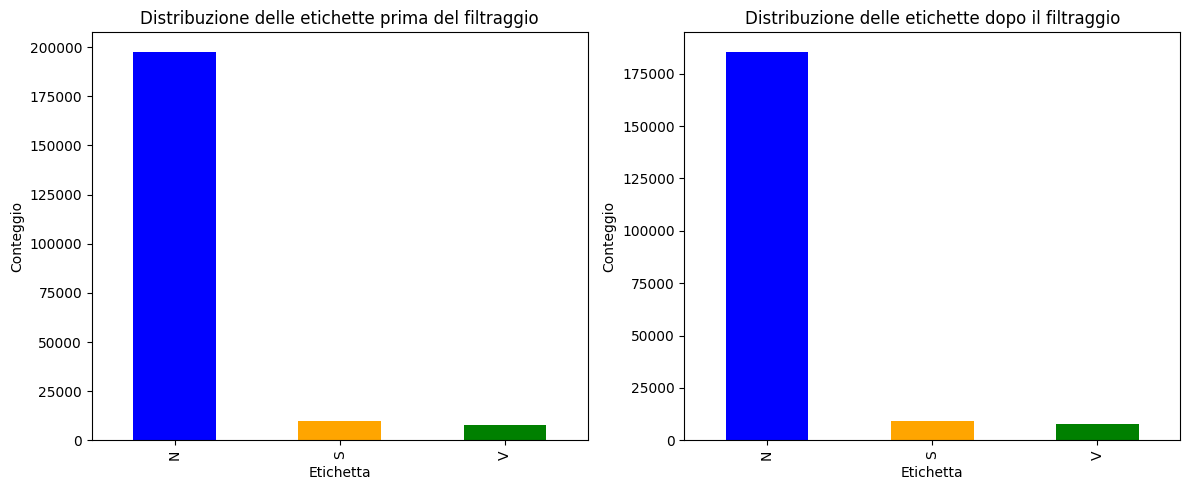

In [36]:
from scipy.stats import zscore

# Scegli le colonne per cui vuoi calcolare lo Z-score
columns_to_check = ['peak_amplitude', 'fft1', 'fft2', 'fft3', 'fft4', 'fft5', 'entropy']

# Calcola lo Z-score e filtra il dataset
z_scores = np.abs(zscore(df_dataset[columns_to_check]))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
df_filtered = df_dataset[~outliers]

# Distribuzione delle etichette prima del filtraggio
label_counts_before = df_dataset['label'].value_counts()
label_counts_after = df_filtered['label'].value_counts()
filtered_beats_list = [beat for i, beat in enumerate(beats_list) if not outliers[i]]

# Stampa i numeri della distribuzione prima del filtraggio
print("Distribuzione delle etichette prima del filtraggio:")
print(label_counts_before)

# Stampa i numeri della distribuzione dopo il filtraggio
print("\nDistribuzione delle etichette dopo il filtraggio:")
print(label_counts_after)

# Visualizzazione della distribuzione delle etichette prima e dopo il filtraggio
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
label_counts_before.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribuzione delle etichette prima del filtraggio')
plt.xlabel('Etichetta')
plt.ylabel('Conteggio')

plt.subplot(1, 2, 2)
label_counts_after.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribuzione delle etichette dopo il filtraggio')
plt.xlabel('Etichetta')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()


#### Create Beats dataset

In [37]:
# Create a new DataFrame for the CNN with the filtered beats and their labels
df_beats = pd.DataFrame({
    'beat': filtered_beats_list,  # Store the filtered beats
    'label': df_filtered['label'].values  # The corresponding labels
})

# Optionally, you can add the subject_id if needed for later reference
df_beats['subject_id'] = df_filtered['subject_id'].values

print(df_beats.head())
print(f"Number of beats in CNN dataset: {df_beats.shape[0]}")

                                                beat label subject_id
0  [-0.08352822059318818, -0.07741457418066558, -...     N       S001
1  [-0.1283664400521754, -0.1254937239009242, -0....     N       S001
2  [-0.1400393440899953, -0.1363870230047287, -0....     N       S001
3  [-0.0756191312915309, -0.06196949629999778, -0...     N       S001
4  [-0.06546820557236065, -0.0648822809682924, -0...     S       S001
Number of beats in CNN dataset: 202388


In [38]:
# Print a summary of the new dataset
print("Dataset for CNN (df_beats):")
print(df_beats.info())
print(df_beats['label'].value_counts())  # Check label distribution

Dataset for CNN (df_beats):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202388 entries, 0 to 202387
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   beat        202388 non-null  object
 1   label       202388 non-null  object
 2   subject_id  202388 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB
None
label
N    185476
S      9297
V      7615
Name: count, dtype: int64


In [39]:
# Save the DataFrame as a pickle file
df_beats.to_pickle('dataset_beats.pkl')

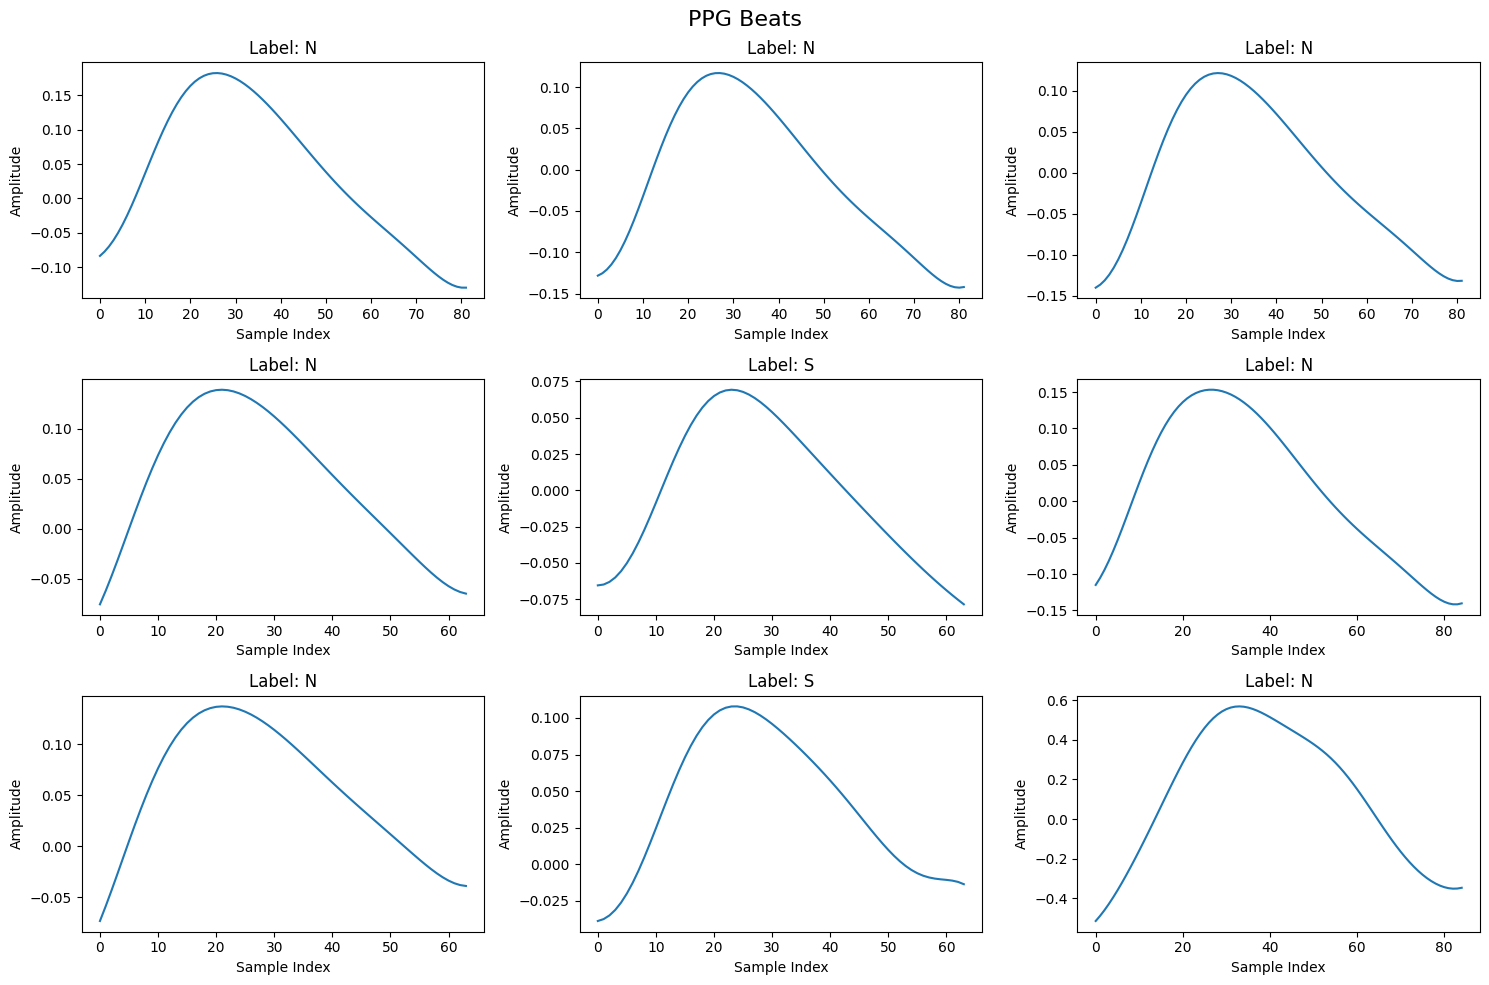

In [40]:
# Plot all the beats in the dataset

# Define a function to plot multiple beats
def plot_beats(beats, labels, num_rows=3, num_cols=3, title='PPG Beats'):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axs.flat):
        ax.plot(beats[i])
        ax.set_title(f'Label: {labels[i]}')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Plot all the beats in the dataset
plot_beats(df_beats['beat'], df_beats['label'], num_rows=3, num_cols=3, title='PPG Beats')

#### Find redundant features

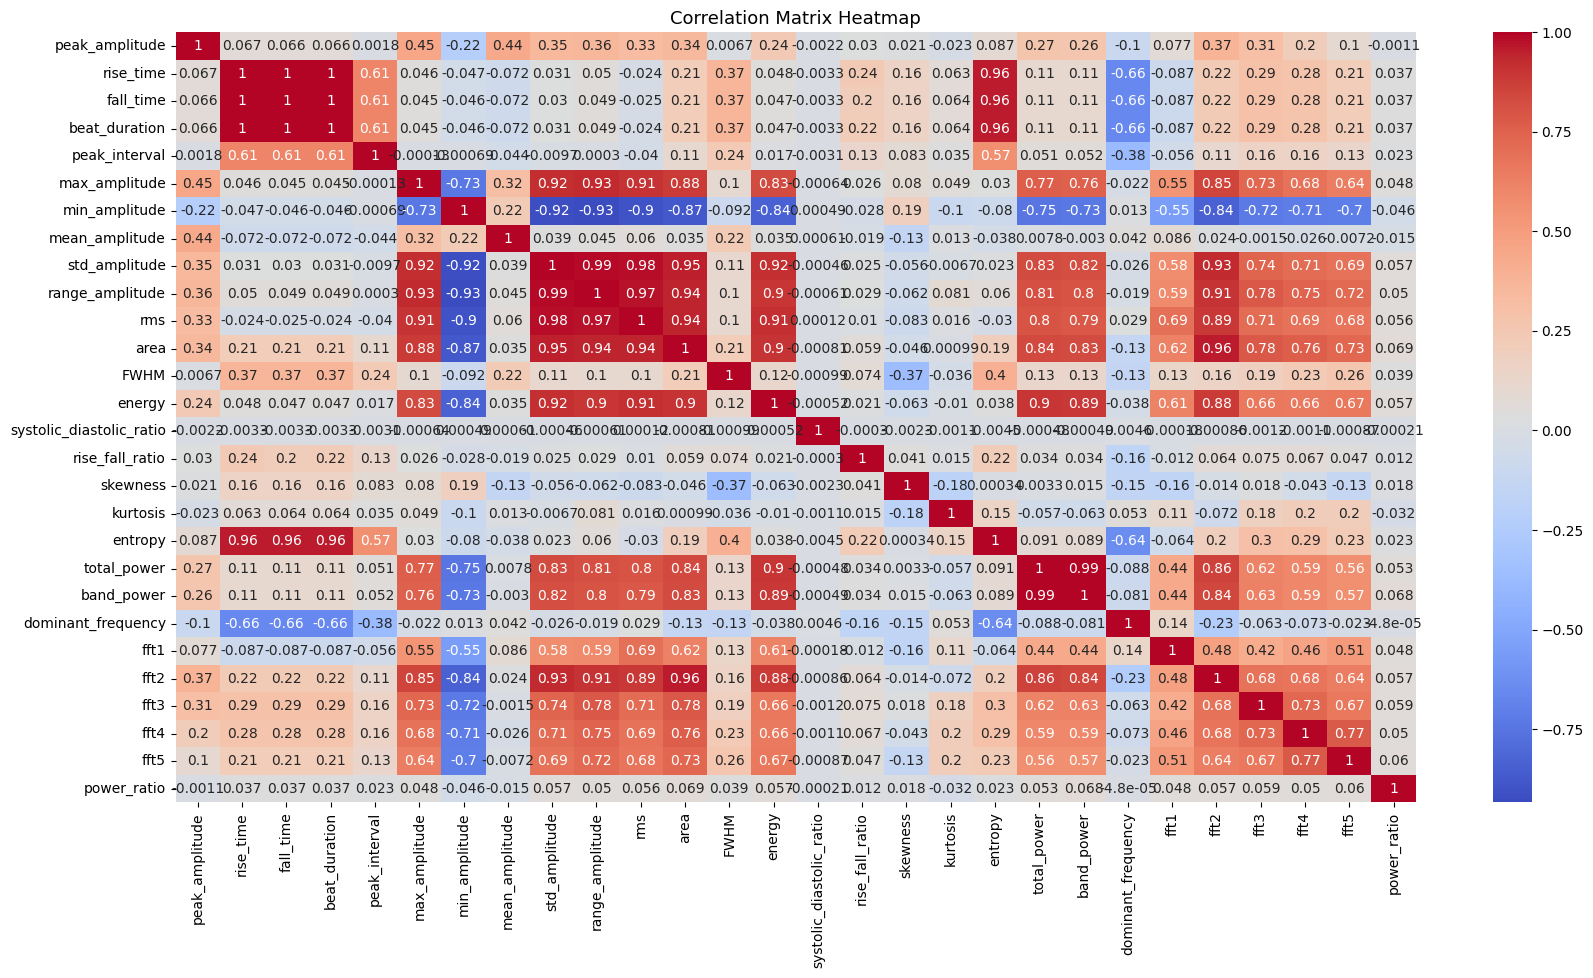

In [41]:
import seaborn as sns

# Visualize correlation among features
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap', fontsize=13)
    plt.show()


# Plot correlation matrix
df_drop = df_filtered.drop(columns=['label', 'subject_id', 'beat_index'])
average_correlation = plot_correlation_matrix(df_drop)

In [42]:
# Drop redundant features: "beat_duration", "band_power", "rms", "range_amplitude", "std"
df_final = df_filtered.drop(columns=["beat_duration", "band_power", "rms", "range_amplitude", "std_amplitude"])
df_final.head()

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,dominant_frequency,fft1,fft2,fft3,fft4,fft5,power_ratio,subject_id,beat_index,label
0,0.180077,0.218750,0.421875,0.640625,0.182377,-0.129712,0.035568,7.611720,0.234375,0.952541,...,1.560976,2.916588,5.748035,1.265770,0.279039,0.107661,4.196146,S001,0,N
1,0.116188,0.218750,0.421875,0.640625,0.116940,-0.142917,-0.011494,6.401779,0.187500,0.632139,...,1.560976,0.942475,4.903048,1.170524,0.241586,0.010196,3.693372,S001,1,N
2,0.121023,0.218750,0.421875,0.648438,0.121389,-0.140039,-0.005806,6.333089,0.195312,0.619593,...,1.560976,0.476099,4.853160,1.269356,0.336398,0.088376,3.344450,S001,2,N
3,0.138627,0.171875,0.328125,0.500000,0.139091,-0.075619,0.046283,4.516074,0.218750,0.440520,...,2.000000,2.962109,3.009263,0.748133,0.258063,0.116591,3.100019,S001,3,N
4,0.068806,0.171875,0.328125,0.781250,0.069293,-0.078520,-0.000457,2.713990,0.156250,0.146076,...,2.000000,0.029221,2.115377,0.439297,0.044651,0.016416,2.799579,S001,4,S


In [43]:
# For each subject in the dataset, calculate the number of samples for each label

# Count the number of samples for each label for each subject
label_counts = df_final.groupby(['subject_id', 'label']).size().unstack(fill_value=0)

# Display the label counts for each subject
label_counts

label,N,S,V
subject_id,,,
S001,2030,261,200
S002,2055,175,3
S003,1757,40,5
S004,1452,49,43
S005,2259,115,208
...,...,...,...
S113,2446,0,5
S114,1693,0,3
S116,1728,0,1


In [44]:
# Save the cleaned dataset to a CSV file
df_final.to_csv('filtered6_dataset.csv', index=False)